<a href="https://colab.research.google.com/github/SampMark/Computational-Thinking/blob/main/classify_solid_waste_using_transfer_learning_consolidated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ♻️ **Classificação de Resíduos Sólidos usando _Transfer Learning_**

Neste notebook, vamos explorar como o apredizado de máquina profundo, especificamente a técnica de _Transfer Learning_ com Redes Neurais Convolucionais (CNNs), pode nos ajudar na separação/classificação entre resíduos sólidos: Orgânicos vs Reciclávies, em tarefas de visão computacional.

### **O Desafio dp Gerenciamento Eficiente de Resíduos Sólidos**
O descarte inadequado e a mistura de resíduos orgânicos com recicláveis representam um grande desafio para municípios e empresas de coleta. A triagem manual é trabalhosa e pode ser lenta, leva à contaminação de materiais que poderiam ser reciclados e o aumentando os custos operacionais.

Neste laboratório iremos desenvolver um modelo de **visão computacional** preliminar capaz de classificar automaticamente imagens de resíduos em duas categorias principais: Orgânico e Reciclável.

### **Solução preliminar: Transfer Learning com VGG16**
Em vez de treinar uma rede neural do zero (o que exigiria uma enorme quantidade de dados e elevado custo computacional), emprega-se o Transfer Learning.

**O que é?**

O _transfer learning_ consiste em se aproveitar o conhecimento (características aprendidas) de um modelo treinado em um problema para aplicá-lo a um novo problema similar. Assim, é possível aproveitar o conhecimento de um modelo mais robusto (por exemplo, VGG16) que já foi treinado em um vasto conjunto de dados (ImageNet, com milhões de imagens).

Para RIBANI e MARENGONI (2019), estes autores  evidenciam como essa técnica se torna essencial frente a altos custos computacionais, desafios de privacidade (ex. LGPD), e à necessidade de soluções mais eficientes em tarefas envolvendo visão computacional. Os autores também reforçam a importância de modelos como VGG, ResNet e MobileNet, e sua reutilização em tarefas variadas.

**Como funciona?**

- Utilizamos as camadas convolucionais da VGG16, que são excelentes extratoras de características visuais (texturas, formas, bordas).

- Removemos a "cabeça" original da VGG16 (suas camadas de classificação).

- Adicionamos nossas próprias camadas no topo, customizadas para a nossa tarefa específica de classificar resíduos.

- Treinamos apenas essas novas camadas (fase de Extração de Características) e, opcionalmente, ajustamos finamente algumas das últimas camadas da VGG16 (fase de Fine-Tuning).

**Vantagens**

- Menor necessidade de dados.
- Treinamento mais rápido.
- Potencialmente, maior acurácia.

### **Fluxo de trabalho em Deep Learning**

1. **Pegar camadas**: utilizar camadas de um modelo previamente treinado.
2. **Congelar camadas**: definir essas camadas como não treináveis para preservar as informações aprendidas.
3. **Adicionar novas camadas**: acrescentar novas camadas treináveis no topo das camadas congeladas.
  * Estas novas camadas aprenderão a converter as características antigas em predições para o novo dataset.
4. **Treinar novas camadas**: treinar apenas as novas camadas com o novo _dataset_.
5. **Fine-Tuning**: descongelar todo o modelo (ou parte dele) e re-treiná-lo no novo _dataset_ com uma taxa de aprendizado muito baixa, o que poderá adaptar incrementalmente as características pré-treinadas aos novos dados.

### 🛠️ **Etapas do Script**

1. **Configuração do ambiente**:
  * Alocação de uma GPU.
  * Instalação e importação das bibliotecas necessárias (TensorFlow, Keras, KaggleHub, Matplotlib, Scikit-learn).
2. **Obtenção e preparação dos dados**:
  * Download do dataset [**Waste Classification Data**](https://www.kaggle.com/datasets/techsash/waste-classification-data/data) via KaggleHub.
  * Organização dos caminhos para os diretórios de treino e teste.
  * Definição das configurações gerais, de parâmetros como tamanho da imagem, batch size, etc.
  * Criação de `ImageDataGenerator` para:
    * Normalizar os pixels das imagens.
    * Aplicar _Data Augmentation_ (aumento de dados) para diversificar o conjunto de treino, tornando o modelo mais robusto.
    * Gerar lotes de dados para alimentar o modelo.
  * Visualização de exemplos de imagens e suas versões aumentadas.
3. **Construção do modelo**:
  * Carregamento da arquitetura VGG16 pré-treinada.
  * Congelamento das camadas convolucionais da VGG16.
  * Adição de uma nova "cabeça" de classificação com camadas `GlobalAveragePooling2D`, `Dense` e `Dropout`.

4. **Treinamento do modelo**:
  * **Fase 1**: Extração de características, treinamento apenas das novas camadas adicionadas.
    * Configuração de callbacks importantes (`EarlyStopping`, `ModelCheckpoint`, `LearningRateScheduler`, `TensorBoard`).
    * Compilação e treinamento do modelo.
    * Visualização das curvas de aprendizado (perda e acurácia).
  * **Fase2**: Ajuste Fino (_Fine-Tuning_):
    * Descongelamento de algumas das últimas camadas da VGG16.
    * Recompilação do modelo com uma taxa de aprendizado menor.
    * Continuação do treinamento.
    * Visualização das novas curvas de aprendizado.

5. **Avaliação do modelo**:
  * Predição no conjunto de teste.
  * Análise do classification_report (precisão, recall, F1-score).
  * Visualização da Matriz de Confusão para entender os tipos de erros do modelo.

6. **Visualização de Predições**:
  * Exibição de imagens de teste aleatórias com seus rótulos reais e os rótulos preditos pelo nosso modelo.


In [15]:
# Setup: aloque uma GPU
!nvidia-smi

Thu Aug 14 19:46:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   34C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
!pip install tensorflow

In [17]:
!pip install kagglehub

In [18]:
# -*- coding: utf-8 -*-
"""
Projeto: Classificação de Resíduos Sólidos com Transfer Learning
Descrição: Script para download, pré-processamento, treinamento e avaliação de um modelo
          de classificação de imagens de resíduos (orgânicos vs. recicláveis) usando o VGG16
          como base para Transfer Learning.
Autor: Marcus Sampaio / GitHub: @SampMark
Data: Maio/2025
"""
# Importações necessárias
import os
import glob
import kagglehub
import numpy as np
import random
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import Model, Sequential, optimizers, callbacks
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Exibir a versão do TensorFlow
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [19]:
# ========================================================
# Download do dataset via KaggleHub
# ========================================================

# Download da última versão do dataset
print("⏳ Baixando dataset do Kaggle...")
path = kagglehub.dataset_download("techsash/waste-classification-data")
print(f"✅ Dataset baixado para: {path}")

# ========================================================
# Configurações dos caminhos
# ========================================================
# A estrutura do dataset inclui as subpastas DATASET/TRAIN e DATASET/TEST
DATASET_ROOT = os.path.join(path, "DATASET")
TRAIN_DIR = os.path.join(DATASET_ROOT, 'TRAIN')
TEST_DIR = os.path.join(DATASET_ROOT, 'TEST')

# Verificação da estrutura
if not os.path.exists(DATASET_ROOT):
    raise FileNotFoundError(f"Estrutura de pastas não encontrada em {DATASET_ROOT}!")
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Diretório de treino não encontrado: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Diretório de teste não encontrado: {TEST_DIR}")

print("\n📂 Estrutura de pastas detectada:")
print(f"Treino: {TRAIN_DIR}")
print(f"Teste: {TEST_DIR}")

⏳ Baixando dataset do Kaggle...
✅ Dataset baixado para: /kaggle/input/waste-classification-data

📂 Estrutura de pastas detectada:
Treino: /kaggle/input/waste-classification-data/DATASET/TRAIN
Teste: /kaggle/input/waste-classification-data/DATASET/TEST


In [20]:
# ========================================================
# Configurações gerais
# ========================================================
SEED = 42                   # Garante reprodutibilidade em operações aleatórias
IMG_HEIGHT = 150            # Altura padrão para redimensionamento das imagens (em pixels)
IMG_WIDTH = 150             # Largura padrão para redimensionamento das imagens (em pixels)
BATCH_SIZE = 32             # Número de amostras por lote durante o treinamento
EPOCHS = 10                 # Número total de épocas para ambas as fases (base + fine-tuning)
VALIDATION_SPLIT = 0.2      # Proporção dos dados de treino reservada para validação (20%)
IMG_DIM = (150, 150)        # Dimensões das imagens para plot

In [22]:
# ========================================================
# Pré-processamento dos Dados
# ========================================================
# Configura geradores de imagem com aumento de dados (data augmentation)
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,                  # Normalização dos valores de pixel para [0,1]
    validation_split=VALIDATION_SPLIT,
    width_shift_range=0.1,              # Deslocamento horizontal aleatório
    height_shift_range=0.1,             # Deslocamento vertical aleatório
    horizontal_flip=True                 # Flip horizontal aleatório
    # zoom_range=0.2,                     # Zoom aleatório (até 20% de ampliação/redução)
    # rotation_range=20,                  # Rotação aleatória ([-20°, +20°])
    # fill_mode='nearest'                 # Preenche pixels criados por transformações
)

# Gerador de validação (sem aumento de dados)
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=VALIDATION_SPLIT
)

# Gerador de teste (apenas normalização)
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

# Cria geradores a partir de diretórios
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED,
    subset='training'
)
val_generator = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED,
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=SEED
)

print(f'Comprimento de "train_generator": {len(train_generator)}')

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
Comprimento de "train_generator": 565


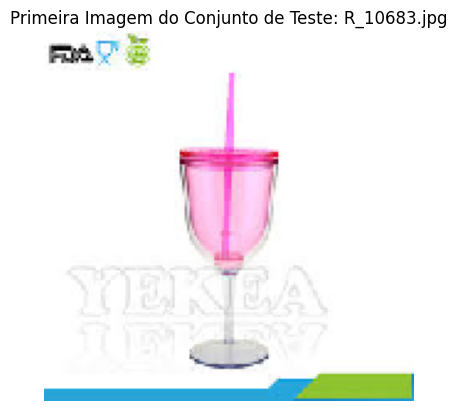

In [32]:
# ========================================================
# Exibir a primeira imagem do conjunto de teste
# ========================================================

# Obter o caminho para a primeira imagem no diretório de teste
# Assumimos que há subdiretórios para classes (Orgânico e Reciclável)
test_image_paths = glob.glob(os.path.join(TEST_DIR, '*/*'))

if test_image_paths:
    first_image_path = test_image_paths[0]

    try:
        # Carregar a imagem. Usamos target_size para redimensionar.
        img = tf.keras.preprocessing.image.load_img(first_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

        # Exibir a imagem
        plt.imshow(img)
        plt.title(f"Primeira Imagem do Conjunto de Teste: {os.path.basename(first_image_path)}")
        plt.axis('off') # Remover eixos
        plt.show()

    except Exception as e:
        print(f"❌ Erro ao carregar ou exibir a imagem: {e}")

else:
    print("Nenhuma imagem encontrada no diretório de teste.")


--- Visualizando Aumentações para a Classe: O ---
Rótulos exibidos para Imagem 1: [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]


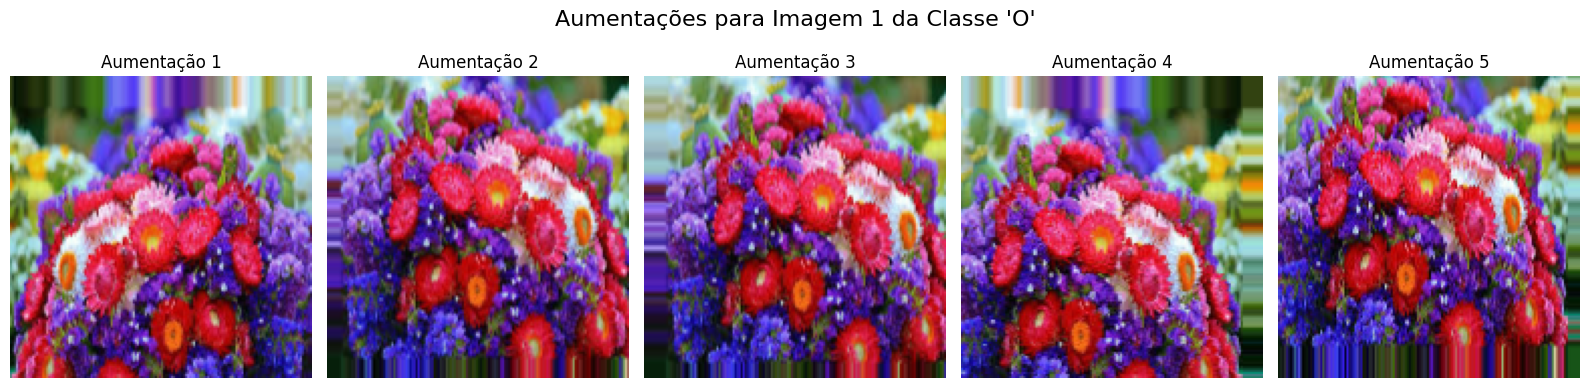


--- Visualizando Aumentações para a Classe: R ---
Rótulos exibidos para Imagem 1: [np.str_('R'), np.str_('R'), np.str_('R'), np.str_('R'), np.str_('R')]


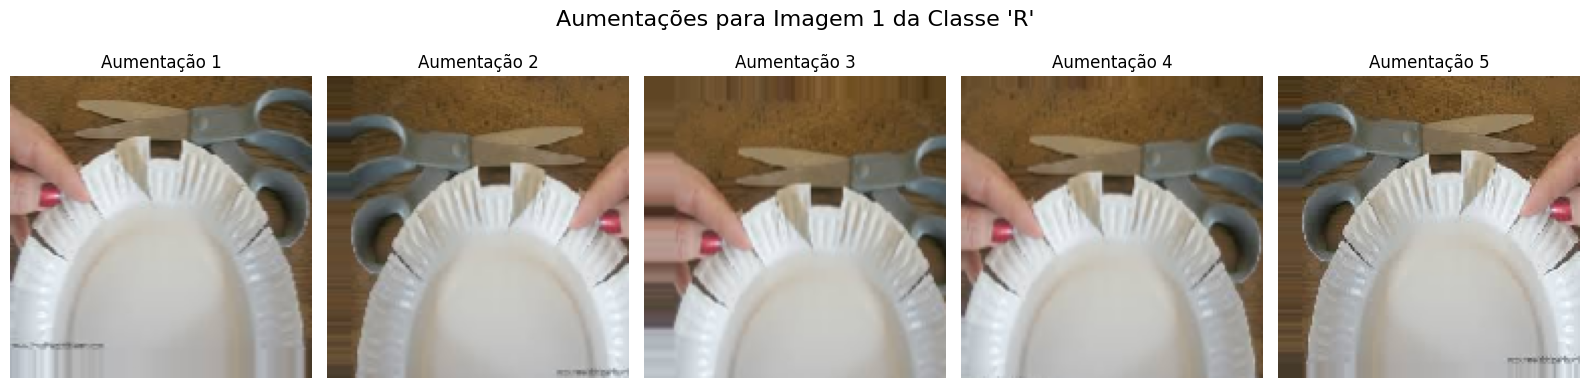

In [23]:
# ========================================================
# Visualização de amostra dos dados por classes
# ========================================================

def visualizar_aumentacoes_por_classe(
    diretorio_treino: str,
    nome_classe: str,
    img_dim: tuple,
    gerador_aumentacao: tf.keras.preprocessing.image.ImageDataGenerator,
    num_exemplos_carregar: int = 1,
    num_aumentacoes_exibir: int = 5,
    id_imagem_inicial: int = 0
) -> None:
    """
    Carrega imagens de uma classe específica do diretório de treino,
    aplica aumentação de dados e exibe os resultados.

    Args:
        diretorio_treino (str): Caminho para o diretório raiz de treinamento.
                               Espera-se que contenha subdiretórios com os nomes das classes.
        nome_classe (str): Nome da subpasta da classe (ex: 'O' (Orgânico) ou 'R'(Reciclável)).
        img_dim (tuple): Dimensões para redimensionar as imagens (altura, largura).
        gerador_aumentacao (tf.keras.preprocessing.image.ImageDataGenerator):
                           Gerador de ImageDataGenerator configurado para aplicar aumentações.
        num_exemplos_carregar (int): Número de imagens originais da classe a serem carregadas.
                                     Para esta função, geralmente queremos ver aumentações de uma
                                     única imagem, então o padrão é 1.
        num_aumentacoes_exibir (int): Quantidade de versões aumentadas a serem exibidas
                                      para cada imagem carregada.
        id_imagem_inicial (int): Índice da imagem a ser selecionada da lista de arquivos
                                 para aplicar as transformações (baseado em 0).
    """
    print(f"\n--- Visualizando Aumentações para a Classe: {nome_classe} ---")

    caminho_classe = os.path.join(diretorio_treino, nome_classe)
    arquivos_classe = glob.glob(os.path.join(caminho_classe, '*'))

    if not arquivos_classe:
        print(f"⚠️ Aviso: Nenhum arquivo de imagem encontrado em '{caminho_classe}'.")
        return

    if id_imagem_inicial >= len(arquivos_classe):
        print(f"⚠️ Aviso: id_imagem_inicial ({id_imagem_inicial}) está fora do intervalo. "
              f"Existem apenas {len(arquivos_classe)} imagens para a classe {nome_classe}.")
        id_imagem_inicial = 0
        if not arquivos_classe : return

    arquivos_selecionados = arquivos_classe[id_imagem_inicial : id_imagem_inicial + num_exemplos_carregar]

    if not arquivos_selecionados:
        print(f"⚠️ Aviso: Não foi possível selecionar imagens com id_imagem_inicial={id_imagem_inicial} e num_exemplos_carregar={num_exemplos_carregar}.")
        return

    imgs_carregadas = []
    labels_carregados = []
    for arquivo_img in arquivos_selecionados:
        try:
            img = tf.keras.preprocessing.image.load_img(arquivo_img, target_size=img_dim)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            imgs_carregadas.append(img_array)
            labels_carregados.append(Path(arquivo_img).parent.name)
        except Exception as e:
            print(f"❌ Erro ao carregar a imagem {arquivo_img}: {e}")
            continue

    if not imgs_carregadas:
        print("Nenhuma imagem foi carregada com sucesso.")
        return

    imgs_np = np.array(imgs_carregadas)
    labels_np = np.array(labels_carregados)

    for i in range(len(imgs_np)):
        img_original = imgs_np[i:i+1]
        label_original = labels_np[i:i+1]

        iterador_aumentacao = gerador_aumentacao.flow(
            img_original,
            y=label_original,
            batch_size=1
        )

        fig, ax = plt.subplots(1, num_aumentacoes_exibir, figsize=(16, 4))
        if num_aumentacoes_exibir == 1:
            ax = [ax]

        fig.suptitle(f"Aumentações para Imagem {i+1} da Classe '{label_original[0]}'", fontsize=16)

        plot_labels = []
        for j in range(num_aumentacoes_exibir):
            batch = next(iterador_aumentacao)
            img_aumentada = batch[0][0]
            label_aumentado = batch[1][0]
            plot_labels.append(label_aumentado)

            ax[j].imshow(img_aumentada)
            ax[j].set_title(f"Aumentação {j+1}")
            ax[j].axis('off')

        print(f"Rótulos exibidos para Imagem {i+1}: {plot_labels}")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

if 'TRAIN_DIR' in locals() and 'train_datagen' in locals() and os.path.exists(TRAIN_DIR):
    visualizar_aumentacoes_por_classe(
        diretorio_treino=TRAIN_DIR,
        nome_classe='O',
        img_dim=IMG_DIM,
        gerador_aumentacao=train_datagen,
        num_exemplos_carregar=1,
        num_aumentacoes_exibir=5,
        id_imagem_inicial=0
    )

    visualizar_aumentacoes_por_classe(
        diretorio_treino=TRAIN_DIR,
        nome_classe='R',
        img_dim=IMG_DIM,
        gerador_aumentacao=train_datagen,
        num_exemplos_carregar=1,
        num_aumentacoes_exibir=5,
        id_imagem_inicial=0
    )
else:
    print("❌ ERRO: As variáveis 'TRAIN_DIR' e/ou 'train_datagen' não estão definidas ou o caminho 'TRAIN_DIR' não existe.")
    print("Por favor, defina-as corretamente.")
    if 'TRAIN_DIR' in locals():
        print(f"TRAIN_DIR atual: {TRAIN_DIR}, Existe: {os.path.exists(TRAIN_DIR)}")
    else:
        print("TRAIN_DIR não está definido.")
    if 'train_datagen' not in locals():
        print("train_datagen não está definido.")

In [24]:
# ========================================================
# Construção do Modelo
# ========================================================
# Carrega VGG16 pré-treinado sem a top layer
base_model = VGG16(
    include_top=False,                      # Exclui as camadas densas finais (classificador original)
    weights='imagenet',                     # Utiliza pesos pré-treinados no ImageNet
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)  # Define a dimensão das imagens de entrada (RGB)
)

# Congela todas as camadas para preservar pesos pré-treinados
for layer in base_model.layers:
    layer.trainable = False

# Monta a cabeça (head) de classificação
model = Sequential([
    base_model,                                 # Base convolucional do VGG16
    GlobalAveragePooling2D(name='gapool'),      # Reduz dimensionalidade espacial
    Dense(512, activation='relu', name='fc1'),  # Camada densa com 512 neurônios
    Dropout(0.3, name='drop1'),                 # Regularização (previne overfitting)
    Dense(512, activation='relu', name='fc2'),  # Segunda camada densa
    Dropout(0.3, name='drop2'),                 # Regularização adicional
    Dense(1, activation='sigmoid', name='output') # Saída binária (0 ou 1)
], name='WasteClassifier')

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "WasteClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gapool (GlobalAveragePooling2D) │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,240,513 (58.14 MB)

 Trainable params: 525,825 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
# ========================================================
# Callbacks
# ========================================================

# Callbacks são funções que podem ser aplicadas em diferentes estágios do
# processo de treinamento (ex: no final de cada época).

def exp_decay(epoch: int, initial_lrate: float = 1e-4, k: float = 0.1) -> float:
    """
    Calcula a taxa de aprendizado para uma determinada época usando um
    cronograma de decaimento exponencial.

    Args:
        epoch (int): A época atual do treinamento (baseado em 0).
        initial_lrate (float, optional): A taxa de aprendizado inicial.
                                         Padrão é 1e-4.
        k (float, optional): A taxa de decaimento. Padrão é 0.1.

    Returns:
        float: A taxa de aprendizado calculada para a época.
    """
    return initial_lrate * np.exp(-k * epoch)

# Lista de callbacks para serem usados durante o treinamento do modelo.
callbacks_list = [
    # EarlyStopping: interrompe o treinamento quando uma métrica monitorada
    # para de melhorar, evitando overfitting e economizando tempo.
    callbacks.EarlyStopping(
        monitor='val_loss',  # Métrica a ser monitorada (perda na validação).
        patience=4,          # Número de épocas sem melhoria após as quais o treinamento será interrompido.
        mode='min',          # O treinamento será interrompido quando a quantidade monitorada parar de diminuir.
        min_delta=0.01       # Mudança mínima na quantidade monitorada para se qualificar como uma melhoria.
    ),

    # ModelCheckpoint: salva o modelo ou seus pesos em um determinado ponto durante o treinamento.
    # É empregado para salvar o melhor modelo encontrado até o momento.
    callbacks.ModelCheckpoint(
        'best_model_vgg16.keras', # Caminho para salvar o modelo (o formato '.keras' é o mais recomendado)
        monitor='val_loss',       # Métrica a ser monitorada para determinar o "melhor" modelo.
        save_best_only=True,      # Se True, o último melhor modelo de acordo com a quantidade monitorada não será sobrescrito.
        mode='min'                # O modelo é salvo quando a quantidade monitorada (val_loss) atinge seu mínimo.
    ),

    # LearningRateScheduler: Ajusta a taxa de aprendizado de acordo com um cronograma.
    # Aqui, ele usa a função `exp_decay` definida anteriormente para diminuir
    # a taxa de aprendizado exponencialmente a cada época.
    callbacks.LearningRateScheduler(exp_decay),

    # TensorBoard: Habilita visualizações para o TensorBoard, uma ferramenta de
    # visualização do TensorFlow. Permite monitorar métricas de treinamento,
    # visualizar o grafo do modelo, histogramas de pesos, etc.
    callbacks.TensorBoard(
        log_dir='./logs' # Diretório onde os arquivos de log do TensorBoard serão salvos.
    )
]

# ========================================================
# Compilação do modelo: Configura o processo de aprendizado.
# ========================================================

# É necessário chamar `compile` antes de treinar o modelo.
model.compile(
    loss='binary_crossentropy', # Função de perda a ser otimizada. 'binary_crossentropy' é
                                # comumente usada para problemas de classificação binária (2 classes).
    optimizer=optimizers.RMSprop(learning_rate=1e-4), # Otimizador a ser usado. RMSprop é um algoritmo
                                                     # de otimização robusto. A taxa de aprendizado
                                                     # inicial é definida como 1e-4 (0.0001).
                                                     # Note que LearningRateScheduler irá ajustar esta taxa posteriormente.
    metrics=['accuracy']        # Lista de métricas a serem avaliadas pelo modelo durante o
                                # treinamento e teste. 'accuracy' calcula a proporção de
                                # predições corretas.
)

# ========================================================
# Treinamento Inicial (Feature Extraction)
# ========================================================
# Ao se utilizar transfer learning, esta é tipicamente a primeira fase de treinamento.
# Aqui, o modelo base (ex: VGG16, EfficientNet) tem suas camadas convolucionais
# congeladas (não treináveis), e apenas as camadas classificadoras adicionadas
# no topo são treinadas. Isso permite que o modelo aprenda a usar as
# características extraídas pelo modelo pré-treinado para a tarefa específica.

history1 = model.fit(
    train_generator,      # Gerador de dados para o conjunto de treinamento.
    epochs=EPOCHS,        # Número total de vezes que o modelo irá iterar sobre todo o
                          # conjunto de dados de treinamento.
    validation_data=val_generator, # Gerador de dados para o conjunto de validação.
                                   # Usado para avaliar a perda e quaisquer métricas do modelo
                                   # no final de cada época.
    callbacks=callbacks_list, # Lista de callbacks (definida acima) a serem aplicados
                              # durante o treinamento.
    verbose=1             # Modo de verbosidade.
                          # 0 = silencioso, 1 = barra de progresso, 2 = uma linha por época.
)

# O objeto 'history1' (History do Keras) armazena informações sobre o
# processo de treinamento, como os valores da função de perda e das métricas
# para cada época, tanto para o conjunto de treinamento quanto para o de validação.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 220s 371ms/step - accuracy: 0.7649 - loss: 0.4922 - val_accuracy: 0.8675 - val_loss: 0.3269 - learning_rate: 1.0000e-04
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 103s 182ms/step - accuracy: 0.8529 - loss: 0.3532 - val_accuracy: 0.8728 - val_loss: 0.3273 - learning_rate: 9.0484e-05
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 103s 183ms/step - accuracy: 0.8699 - loss: 0.3107 - val_accuracy: 0.8754 - val_loss: 0.3165 - learning_rate: 7.4082e-05
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 102s 181ms/step - accuracy: 0.8720 - loss: 0.3051 - val_accuracy: 0.8779 - val_loss: 0.3120 - learning_rate: 5.4881e-05
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 101s 179ms/step - accuracy: 0.8863 - loss: 0.2860 - val_accuracy: 0.8772 - val_loss: 0.3151 - learning_rate: 3.6788e-05
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 102s 180ms/step - accuracy: 0.8850 - loss: 0.2866 - val_accuracy: 0.8739 - val_loss: 0.3241 - learning_rate: 2.2313e-05
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 

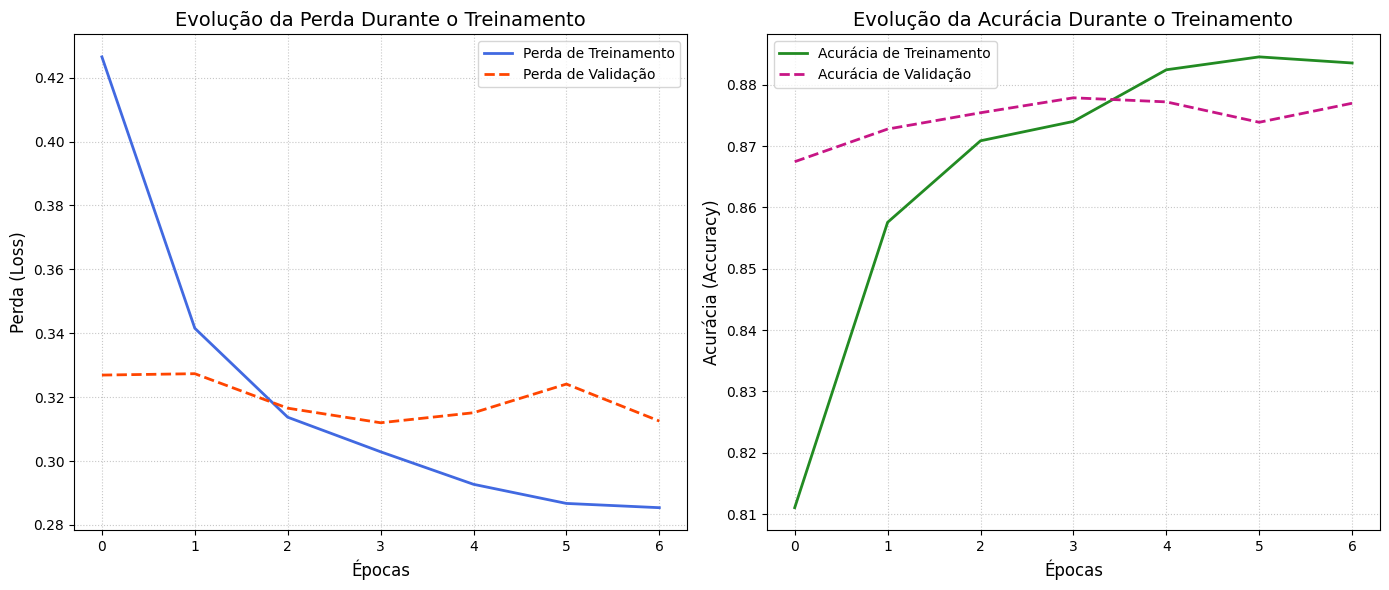

In [26]:
# ========================================================
# Visualização das Curvas de Aprendizado (Perda e Acurácia)
# ========================================================
# Esta seção do código plota as curvas de perda (loss) e acurácia (accuracy)
# do treinamento e da validação ao longo das épocas. Visualizar essas curvas
# é fundamental para entender o desempenho do modelo, identificar overfitting,
# underfitting ou se o treinamento pode ser estendido.

# Atribui o histórico de treinamento à variável 'history'.
history = history1

# Cria uma figura e um conjunto de subplots.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# --- Primeiro Subplot: Curva de Perda (Loss Curve) ---
ax[0].plot(history.history['loss'], label='Perda de Treinamento', color='royalblue', linewidth=2)
ax[0].plot(history.history['val_loss'], label='Perda de Validação', color='orangered', linestyle='--', linewidth=2)
ax[0].set_title('Evolução da Perda Durante o Treinamento', fontsize=14) # Título do subplot
ax[0].set_xlabel('Épocas', fontsize=12)                                 # Rótulo do eixo X
ax[0].set_ylabel('Perda (Loss)', fontsize=12)                           # Rótulo do eixo Y
ax[0].legend(fontsize=10)                                               # Adiciona a legenda ao gráfico
ax[0].grid(True, linestyle=':', alpha=0.7)                              # Adiciona uma grade para facilitar a leitura

# --- Segundo Subplot: Curva de Acurácia (Accuracy Curve) ---
ax[1].plot(history.history['accuracy'], label='Acurácia de Treinamento', color='forestgreen', linewidth=2)
ax[1].plot(history.history['val_accuracy'], label='Acurácia de Validação', color='mediumvioletred', linestyle='--', linewidth=2)
ax[1].set_title('Evolução da Acurácia Durante o Treinamento', fontsize=14)  # Título do subplot
ax[1].set_xlabel('Épocas', fontsize=12)                                     # Rótulo do eixo X
ax[1].set_ylabel('Acurácia (Accuracy)', fontsize=12)                        # Rótulo do eixo Y
ax[1].legend(fontsize=10)                                                   # Adiciona a legenda ao gráfico
ax[1].grid(True, linestyle=':', alpha=0.7)                                  # Adiciona uma grade para facilitar a leitura

# Ajusta automaticamente os parâmetros do subplot para fornecer um layout adequado.
plt.tight_layout()

# Exibe os dois subplots.
plt.show()

In [27]:
# ========================================================
# Fine-Tuning
# ========================================================
# Descongela últimas camadas do base_model
unfreeze = False
for layer in base_model.layers:
    if layer.name == 'block5_conv3':
        unfreeze = True
    layer.trainable = unfreeze

# Recompila o modelo para aplicar as alterações de trainable
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),  # taxa menor para fine-tuning
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 112s 190ms/step - accuracy: 0.8878 - loss: 0.2773 - val_accuracy: 0.8759 - val_loss: 0.3096 - learning_rate: 1.0000e-05
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 103s 181ms/step - accuracy: 0.9037 - loss: 0.2412 - val_accuracy: 0.8874 - val_loss: 0.2963 - learning_rate: 9.0484e-06
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 103s 182ms/step - accuracy: 0.9050 - loss: 0.2351 - val_accuracy: 0.8836 - val_loss: 0.3023 - learning_rate: 7.4082e-06
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 103s 182ms/step - accuracy: 0.9139 - loss: 0.2228 - val_accuracy: 0.8881 - val_loss: 0.2918 - learning_rate: 5.4881e-06
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 103s 182ms/step - accuracy: 0.9132 - loss: 0.2231 - val_accuracy: 0.8859 - val_loss: 0.2970 - learning_rate: 3.6788e-06
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 102s 180ms/step - accuracy: 0.9186 - loss: 0.2109 - val_accuracy: 0.8825 - val_loss: 0.3050 - learning_rate: 2.2313e-06


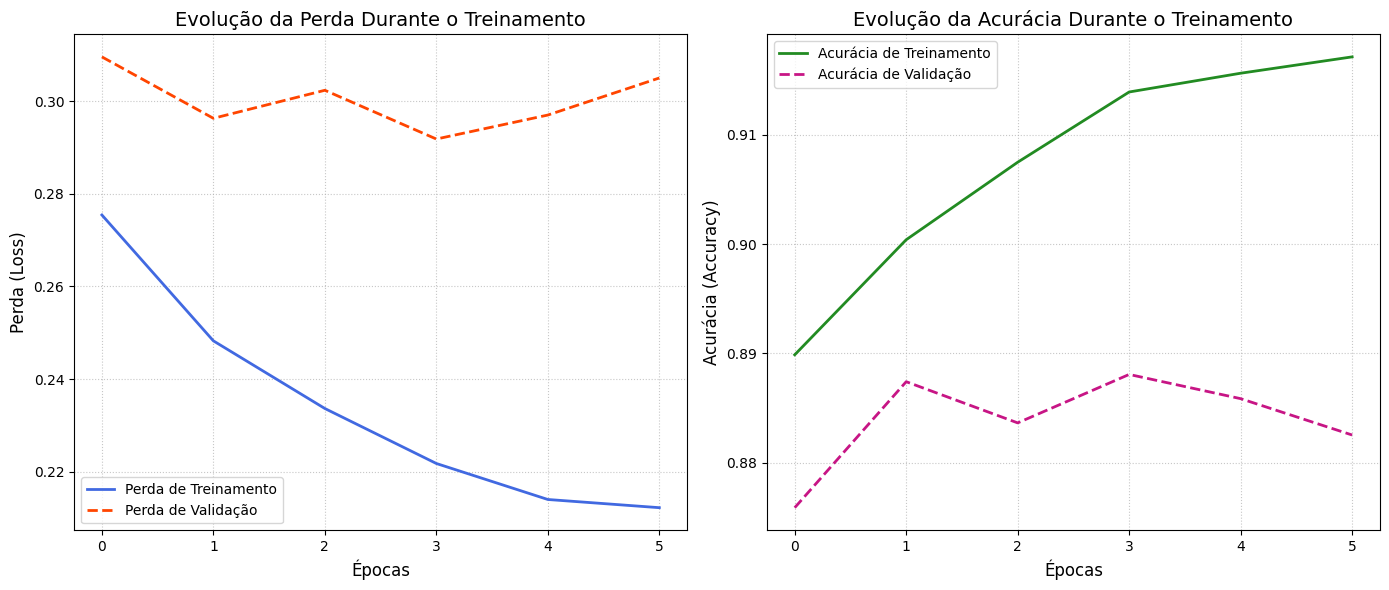

In [28]:
# ========================================================
# Fine-Tuning: visualização das Curvas de Aprendizado
# ========================================================

# Atribui o histórico de treinamento Fine-Tuning à variável 'history'.
history = history2

# Cria uma figura e um conjunto de subplots.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# --- Primeiro Subplot: Curva de Perda (Loss Curve) ---
ax[0].plot(history.history['loss'], label='Perda de Treinamento', color='royalblue', linewidth=2)
ax[0].plot(history.history['val_loss'], label='Perda de Validação', color='orangered', linestyle='--', linewidth=2)
ax[0].set_title('Evolução da Perda Durante o Treinamento', fontsize=14) # Título do subplot
ax[0].set_xlabel('Épocas', fontsize=12)                                 # Rótulo do eixo X
ax[0].set_ylabel('Perda (Loss)', fontsize=12)                           # Rótulo do eixo Y
ax[0].legend(fontsize=10)                                               # Adiciona a legenda ao gráfico
ax[0].grid(True, linestyle=':', alpha=0.7)                              # Adiciona uma grade para facilitar a leitura

# --- Segundo Subplot: Curva de Acurácia (Accuracy Curve) ---
ax[1].plot(history.history['accuracy'], label='Acurácia de Treinamento', color='forestgreen', linewidth=2)
ax[1].plot(history.history['val_accuracy'], label='Acurácia de Validação', color='mediumvioletred', linestyle='--', linewidth=2)
ax[1].set_title('Evolução da Acurácia Durante o Treinamento', fontsize=14)  # Título do subplot
ax[1].set_xlabel('Épocas', fontsize=12)                                     # Rótulo do eixo X
ax[1].set_ylabel('Acurácia (Accuracy)', fontsize=12)                        # Rótulo do eixo Y
ax[1].legend(fontsize=10)                                                   # Adiciona a legenda ao gráfico
ax[1].grid(True, linestyle=':', alpha=0.7)                                  # Adiciona uma grade para facilitar a leitura

# Ajusta automaticamente os parâmetros do subplot para fornecer um layout adequado
# e evitar sobreposição de títulos ou rótulos.
plt.tight_layout()

# Exibe a figura com os dois subplots.
plt.show()

In [33]:
# ========================================================
# Avaliação no Conjunto de Teste
# ========================================================
predictions = model.predict(test_generator, verbose=0)
pred_labels = (predictions >= 0.5).astype(int).ravel()
true_labels = test_generator.classes

print(classification_report(true_labels, pred_labels, target_names=['Orgânico', 'Reciclável']))

              precision    recall  f1-score   support

    Orgânico       0.83      0.95      0.89      1401
  Reciclável       0.93      0.75      0.83      1112

    accuracy                           0.86      2513
   macro avg       0.88      0.85      0.86      2513
weighted avg       0.87      0.86      0.86      2513



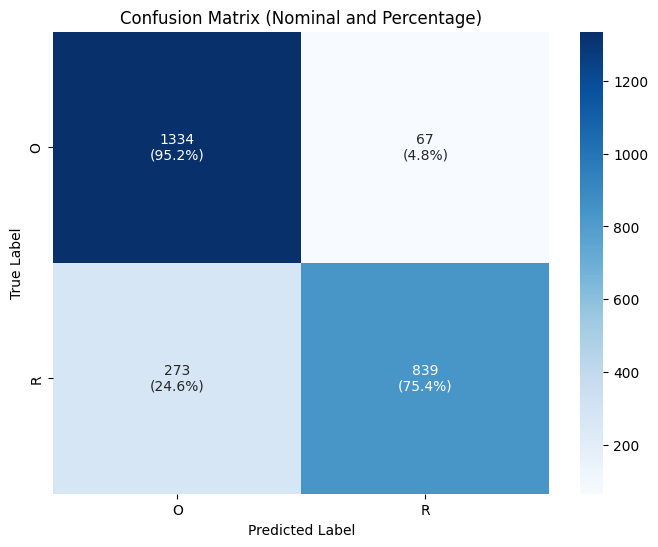

In [34]:
# ========================================================
# Visualização da Matriz de Confusão
# ========================================================

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Calcular matriz de confusão percentual
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Combinar valores nominais e percentuais para anotações
annot_labels = np.asarray([f'{nominal}\n({percent:.1%})' for nominal, percent in zip(conf_matrix.flatten(), conf_matrix_percent.flatten())]).reshape(conf_matrix.shape)

# Definir os nomes de classes com base em class_indices do gerador
class_names = list(test_generator.class_indices.keys())
class_names.sort() # Garantir a ordem alfabética para corresponder aos índices de classe

# Plote a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='s', cmap='Blues', xticklabels=class_names, yticklabels=class_names) # Use fmt='s' for string annotations
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Nominal and Percentage)')
plt.show()

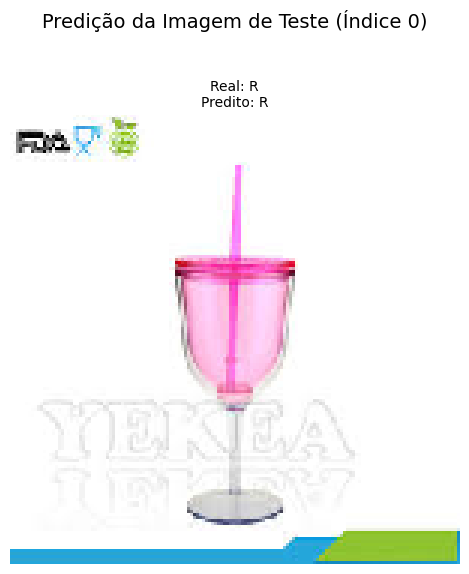

In [36]:
# ========================================================
# Visualização de uma imagem de teste com a predição do modelo
# (após Fine-Tuning)
# ========================================================

# Índice da imagem a ser plotada (a primeira imagem)
index_to_plot = 0 # Usamos 0 para a primeira imagem

# Carregar a imagem de teste
if 'all_test_imgs_np' in locals() and 'all_test_labels_indices_np' in locals():
    if index_to_plot < len(all_test_imgs_np):
        img_to_predict = all_test_imgs_np[index_to_plot]
        true_label_index = all_test_labels_indices_np[index_to_plot]

        # Expandir as dimensões para que a imagem tenha o formato (1, IMG_HEIGHT, IMG_WIDTH, 3)
        img_to_predict_expanded = np.expand_dims(img_to_predict, axis=0)

        # Realizar a predição usando o modelo após a fase de Fine-Tuning ('model' atual)
        # Assumindo que all_test_imgs_np não está normalizado (como parece ser o caso no último bloco de visualização):
        predictions_raw = model.predict(img_to_predict_expanded / 255.0, verbose=0)

        # Converter a predição para rótulo binário (0 ou 1)
        predicted_label_index = (predictions_raw >= 0.5).astype(int)[0][0]

        # Mapear índices para nomes de classe
        # Garantir que mapa_indice_para_nome está disponível
        if 'mapa_indice_para_nome' in locals():
             true_label_name = mapa_indice_para_nome.get(true_label_index, f"Índice_{true_label_index}")
             predicted_label_name = mapa_indice_para_nome.get(predicted_label_index, f"Índice_{predicted_label_index}")
        else:
            print("⚠️ Aviso: 'mapa_indice_para_nome' não está definido. Exibindo índices numéricos.")
            true_label_name = str(true_label_index)
            predicted_label_name = str(predicted_label_index)


        # Plotar a imagem com rótulos
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        plot_imagem_com_titulo_em_eixo(
            ax,
            img_to_predict,
            "Modelo Fine-Tuning",
            true_label_name,
            predicted_label_name
        )
        plt.suptitle(f'Predição da Imagem de Teste (Índice {index_to_plot})', fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    else:
        print(f"❌ ERRO: O índice {index_to_plot} está fora do intervalo. Existem apenas {len(all_test_imgs_np)} imagens de teste carregadas.")
else:
    print("❌ ERRO: As variáveis 'all_test_imgs_np' e/ou 'all_test_labels_indices_np' não estão definidas.")
    print("Por favor, execute a seção 'Carregamento e Preparação dos Dados de Teste' primeiro.")

Carregando imagens de teste...


100%|██████████| 2513/2513 [00:02<00:00, 854.46it/s]


Carregamento de imagens de teste concluído.
Carregadas 2513 imagens de teste.


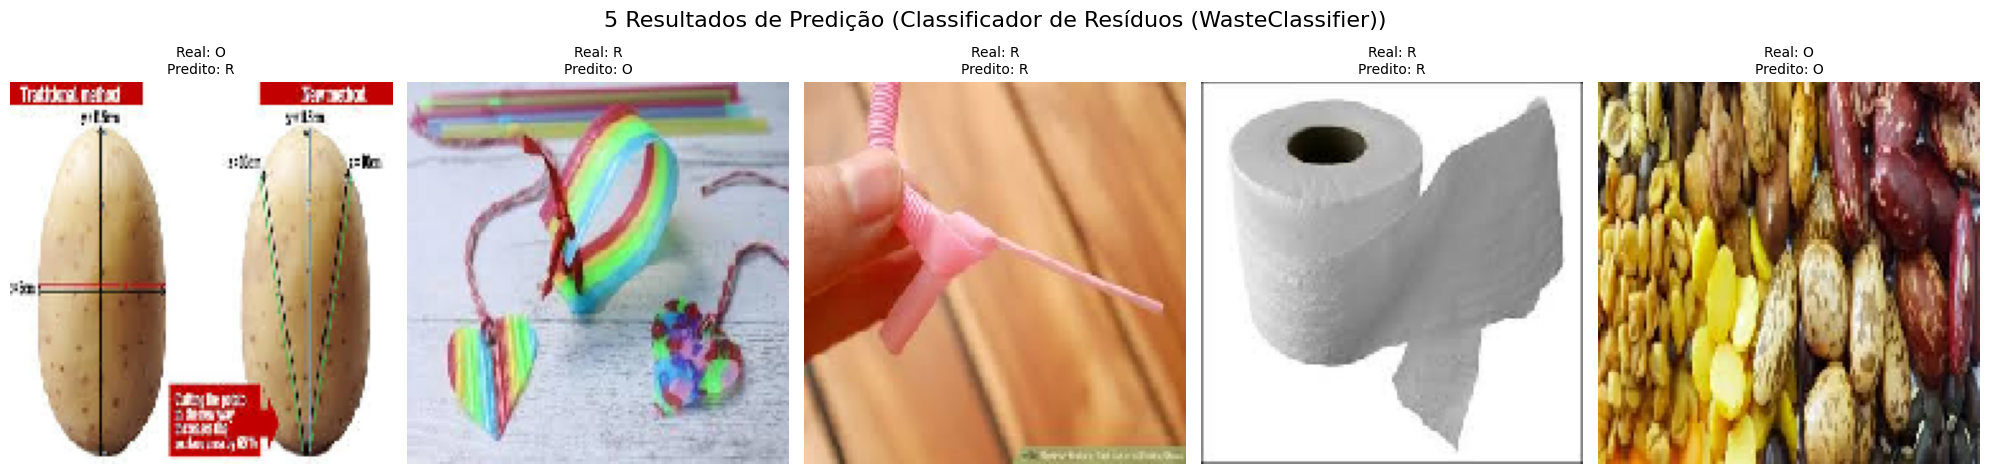

In [35]:
# ========================================================
#  Plota imagens com o rótulo real e o predito no título
# ========================================================
def plot_imagem_com_titulo_em_eixo(ax: plt.Axes, imagem: np.ndarray, nome_modelo: str, rotulo_real: str, rotulo_predito: str) -> None:
    """
    Plota uma imagem em um eixo (Axes) do Matplotlib com o rótulo real e o predito no título.

    Args:
        ax (plt.Axes): O eixo do Matplotlib onde a imagem será plotada.
        imagem (np.ndarray): A imagem a ser plotada (como um array NumPy).
        nome_modelo (str): Nome do modelo para exibição no título.
        rotulo_real (str): O rótulo verdadeiro da imagem.
        rotulo_predito (str): O rótulo previsto pelo modelo para a imagem.
    """
    ax.imshow(imagem.astype('uint8')) # Garante que a imagem esteja no formato uint8 para exibição
    titulo = f"Real: {rotulo_real}\nPredito: {rotulo_predito}"
    ax.set_title(titulo, fontsize=10)
    ax.axis('off')

# --- Carregamento e Preparação dos Dados de Teste ---
# Esta seção carrega as imagens de teste. Caso o conjunto de teste seja ainda maior,
# considere carregar apenas uma amostra ou imagens específicas para visualização.

# A partir de glob obtém-se os caminhos de arquivos no diretório de teste
test_files = glob.glob(os.path.join(TEST_DIR, '*/*')) # Encontra arquivos em subdiretórios de classe

all_test_imgs = []
all_test_labels_indices = [] # Armazenará os índices numéricos dos rótulos

# Obter nomes das classes e criar um mapa de rótulos
if 'test_generator' not in locals() or test_generator is None:
    raise ValueError("A variável 'test_generator' não está definida ou é None. "
                     "Ela é necessária para obter os mapeamentos de classe.")

nomes_classes = list(test_generator.class_indices.keys())
# Ordena para garantir consistência, embora class_indices possam estar ordenadas
# alfabeticamente por padrão no Keras.
# No entanto, é mais seguro usar o mapeamento direto de class_indices.
mapa_indice_para_nome = {v: k for k, v in test_generator.class_indices.items()}
# Se precisar de nome para índice (embora Path().parent.name já dê o nome da classe):
# mapa_nome_para_indice = test_generator.class_indices

print("Carregando imagens de teste...")
for file_path in tqdm(test_files):
    try:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        all_test_imgs.append(img_array)

        # Extrai o nome da classe (rótulo) do nome do diretório pai
        nome_rotulo_classe = Path(file_path).parent.name
        # Converte o nome da classe para seu índice numérico usando o test_generator
        all_test_labels_indices.append(test_generator.class_indices[nome_rotulo_classe])

    except Exception as e:
        print(f"Não foi possível carregar a imagem {file_path}: {e}")
        continue

if not all_test_imgs:
    print("Nenhuma imagem de teste foi carregada. Verifique o caminho TEST_DIR e o conteúdo das pastas.")
else:
    all_test_imgs_np = np.array(all_test_imgs)
    all_test_labels_indices_np = np.array(all_test_labels_indices)

    print("Carregamento de imagens de teste concluído.")
    print(f"Carregadas {len(all_test_imgs_np)} imagens de teste.")

    # --- Função para Visualização dos Resultados (aleatoriamente) ---
    def visualizar_n_resultados(
        imagens: np.ndarray,
        rotulos_reais_indices: np.ndarray,
        mapa_idx_para_nome_classe: dict,
        modelo_keras: tf.keras.Model,
        num_resultados: int = 5,
        nome_modelo_exibicao: str = "Classificador"
    ) -> None:
        """
        Seleciona, prevê e plota um número especificado de resultados de teste lado a lado.

        Args:
            imagens (np.ndarray): Array de todas as imagens de teste carregadas.
            rotulos_reais_indices (np.ndarray): Array dos índices dos rótulos reais para as imagens.
            mapa_idx_para_nome_classe (dict): Dicionário para mapear índices de classe para nomes de classe.
            modelo_keras (tf.keras.Model): O modelo Keras treinado.
            num_resultados (int, optional): Número de resultados a serem exibidos. Padrão é 5.
            nome_modelo_exibicao (str, optional): Nome do modelo para exibição. Padrão é "Classificador".
        """
        if len(imagens) == 0:
            print("Nenhuma imagem disponível para visualização.")
            return
        if num_resultados > len(imagens):
            print(f"Aviso: Solicitados {num_resultados} resultados, mas apenas {len(imagens)} imagens disponíveis. "
                  f"Exibindo {len(imagens)} resultados.")
            num_resultados = len(imagens)

        # Seleciona 'num_resultados' índices aleatórios das imagens disponíveis
        indices_selecionados = random.sample(range(len(imagens)), num_resultados)

        imgs_selecionadas = imagens[indices_selecionados]
        rotulos_reais_selecionados_indices = rotulos_reais_indices[indices_selecionados]

        # Realiza predições para as imagens selecionadas em um único lote
        # predicoes_batch_raw = modelo_keras.predict(imgs_selecionadas / 255.0, verbose=0)
        # Como as imagens já estão normalizadas (carregadas através de um gerador com rescale)
        predicoes_batch_raw = modelo_keras.predict(imgs_selecionadas, verbose=0)

        # Converte as probabilidades de predição em índices de classe
        # Para classificação binária com saída sigmoide:
        if predicoes_batch_raw.shape[-1] == 1: # Saída sigmoide
            predicoes_indices = (predicoes_batch_raw >= 0.5).astype(int).ravel()
        # Para classificação multiclasse com saída softmax (ou binária com 2 neurônios softmax):
        else: # Saída softmax
            predicoes_indices = np.argmax(predicoes_batch_raw, axis=1)

        # Define o layout dos subplots
        # Ajuste 'figsize' conforme necessário para o tamanho da sua tela/output.
        fig, axes = plt.subplots(1, num_resultados, figsize=(num_resultados * 4, 5))
        if num_resultados == 1: # Matplotlib retorna um único Axes se nrows*ncols=1
            axes = [axes]

        fig.suptitle(f'{num_resultados} Resultados de Predição ({nome_modelo_exibicao})', fontsize=16)

        for i in range(num_resultados):
            img_para_plotar = imgs_selecionadas[i]
            rotulo_real_idx = rotulos_reais_selecionados_indices[i]
            rotulo_predito_idx = predicoes_indices[i]

            # Converte índices para nomes de classe
            nome_rotulo_real = mapa_idx_para_nome_classe.get(rotulo_real_idx, f"Índice_{rotulo_real_idx}")
            nome_rotulo_predito = mapa_idx_para_nome_classe.get(rotulo_predito_idx, f"Índice_{rotulo_predito_idx}")

            plot_imagem_com_titulo_em_eixo(
                axes[i],
                img_para_plotar,
                nome_modelo_exibicao,
                nome_rotulo_real,
                nome_rotulo_predito
            )

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para caber o supertítulo
        plt.show()

    # --- Chamada da Função de Visualização ---
    visualizar_n_resultados(
        all_test_imgs_np,
        all_test_labels_indices_np,
        mapa_indice_para_nome,
        model, # Modelo Keras treinado
        num_resultados=5,
        nome_modelo_exibicao="Classificador de Resíduos (WasteClassifier)"
    )

# **Referências**

* CHOLLET, F. Transfer learning & fine-tuning. Keras, 2023. Disponível em: https://keras.io/guides/transfer_learning/. Acesso em: 26 abril 2025.

* GOODFELLOW, Ian; BENGIO, Yoshua; COURVILLE, Aaron. **Deep Learning**. Cambridge: MIT Press, 2016. Cap. 9 – Convolutional Networks, p. 323–366. Disponível em: https://www.deeplearningbook.org/. Acesso em: 27 janeiro 2025.

* RIBANI, Ricardo; MARENGONI, Mauricio. **A survey of transfer learning for convolutional neural networks**. In: SIBGRAPI-T – 2019 32nd SIBGRAPI Conference on Graphics, Patterns and Images Tutorials. Anais [...]. IEEE, 2019. p. 47–57. DOI: 10.1109/SIBGRAPI-T.2019.00010. Disponível em: https://www.researchgate.net/publication/337794654. Acesso em: 10 maio 2025.